In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
classes = (1+4, 17+17, 17+42)

### Загрузка датасета

In [3]:
#conda install pytorch torchvision cpuonly -c pytorch

In [4]:
'''
import requests

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
response = requests.get(url)
print(response.status_code)
with open('cifar-100-python.tar.gz', 'wb') as f:
    f.write(response.content)

!tar -xvzf cifar-100-python.tar.gz
!rm cifar-100-python.tar.gz
'''

'\nimport requests\n\nurl = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"\nresponse = requests.get(url)\nprint(response.status_code)\nwith open(\'cifar-100-python.tar.gz\', \'wb\') as f:\n    f.write(response.content)\n\n!tar -xvzf cifar-100-python.tar.gz\n!rm cifar-100-python.tar.gz\n'

## Чтение тренировочной и тестовой выборки

In [5]:
with open('cifar-100-python/meta', 'rb') as f:
    data_meta = pickle.load(f, encoding='latin1')

label_classes = list()
for index, value in enumerate(classes):
    print(index, ": ", value, "\t", data_meta["fine_label_names"][value], sep="")
    
    label_classes.append(data_meta["fine_label_names"][value])    

0: 5	bed
1: 34	fox
2: 59	pine_tree


In [6]:
def create_arrays_xy(data, classes):
    x = data['data'].reshape(-1, 3, 32, 32)
    x = np.transpose(x, [0, 2, 3, 1]) # NCHW -> NHWC
    
    y = np.array(data['fine_labels'])
    mask = np.isin(y, classes)
    x = x[mask].copy()
    y = y[mask].copy()
    y = np.unique(y, return_inverse=1)[1]
    
    return x, y

data_train is <class 'dict'>
1 fox


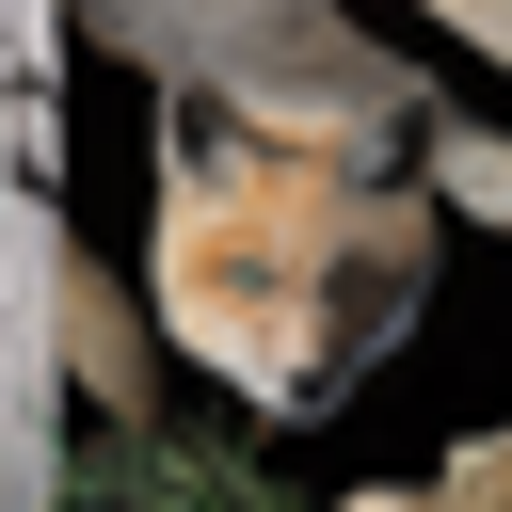

In [7]:
# Чтение тренировочной выборки (обучающих данных)
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
print("data_train is", type(data_train))

# Чтение тестовой выборки (тестовых данных)
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')


train_X, train_y = create_arrays_xy(data_train, classes)
del data_train
test_X, test_y = create_arrays_xy(data_test, classes)
del data_test
index = 1000
print(train_y[index], label_classes[train_y[index]])
Image.fromarray(train_X[index]).resize((512,512))

In [8]:
print(train_y.shape[0])

1500


### Создание Pytorch DataLoader'a

In [9]:
# Указываем размер батча
batch_size = 50

dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(classes))/1.  # .to(torch.float64) 
    
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f05b96a0950>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f05b96aac50>}

### Обучение

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, stride=1, padding=2)
        
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(6)
        self.bn3 = nn.BatchNorm2d(12)
        self.bn4 = nn.BatchNorm2d(24)
        self.bn5 = nn.BatchNorm2d(48)
        
        self.fc1 = nn.Linear(48*2*2, 96)
        self.fc2 = nn.Linear(96, 48)
        self.fc3 = nn.Linear(48, 3)

    def forward(self, x):
        
        x = x.permute(0, 3, 1, 2)  # NHWC -> NCHW
        
        #print(x.shape)
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.max_pool(x)

        x = self.bn2(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.max_pool(x)

        x = self.bn3(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.max_pool(x)

        x = self.bn4(x)
        x = self.conv4(x)
        x = F.leaky_relu(x)
        x = self.max_pool(x)

        #print(x.shape)
        x = self.bn5(x)
        x = x.reshape(-1, 48*2*2)
        x =  self.fc1(x)
        x = F.leaky_relu(x)

        x = self.fc2(x)
        x = F.leaky_relu(x)

        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x
        
model = CNN()
model  

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=192, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_f

In [11]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# Оптимизатор
# lr - шаг обучения. Данный параметр можно изменять.
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [12]:
# Укажем количество эпох.
# Увеличение количества эпох приводит к увеличению времени работы программы.
# Чем больше эпох мы обучаем, тем точнее обучается модель, но есть риск наступления переобучения.

EPOCHS = 200
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in tqdm(range(EPOCHS)):  # проход по набору данных несколько раз
    running_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader['train']):
        # (X, y) = (inputs, labels)
    
        # прямой + обратный проходы + оптимизация
        outputs = model(X)
        loss = criterion(outputs, y)

        
        # Backpropagation
        loss.backward()
        #Для обновления параметров нейронной сети используется метод step, применённый к экземпляру класса оптимизатора.
        optimizer.step()
        
        # очищение градиентов
        optimizer.zero_grad()

        # для подсчёта статистик
        running_loss += loss.item()
    
            
    print(f'epoch: {epoch + 1}, loss: {running_loss / steps_per_epoch:.3f}')
print('Обучение закончено')

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 1, loss: 1.094
epoch: 2, loss: 1.086
epoch: 3, loss: 1.078
epoch: 4, loss: 1.068
epoch: 5, loss: 1.056
epoch: 6, loss: 1.041
epoch: 7, loss: 1.019
epoch: 8, loss: 0.992
epoch: 9, loss: 0.961
epoch: 10, loss: 0.923
epoch: 11, loss: 0.885
epoch: 12, loss: 0.850
epoch: 13, loss: 0.821
epoch: 14, loss: 0.796
epoch: 15, loss: 0.778
epoch: 16, loss: 0.764
epoch: 17, loss: 0.750
epoch: 18, loss: 0.738
epoch: 19, loss: 0.727
epoch: 20, loss: 0.717
epoch: 21, loss: 0.711
epoch: 22, loss: 0.694
epoch: 23, loss: 0.685
epoch: 24, loss: 0.678
epoch: 25, loss: 0.668
epoch: 26, loss: 0.666
epoch: 27, loss: 0.655
epoch: 28, loss: 0.648
epoch: 29, loss: 0.645
epoch: 30, loss: 0.631
epoch: 31, loss: 0.628
epoch: 32, loss: 0.626
epoch: 33, loss: 0.620
epoch: 34, loss: 0.618
epoch: 35, loss: 0.612
epoch: 36, loss: 0.608
epoch: 37, loss: 0.599
epoch: 38, loss: 0.599
epoch: 39, loss: 0.595
epoch: 40, loss: 0.593
epoch: 41, loss: 0.589
epoch: 42, loss: 0.587
epoch: 43, loss: 0.584
epoch: 44, loss: 0.5

### Тестирование

In [13]:
running_loss = 0
#Для перевода модели в состояние проверки необходимо вызвать метод eval. После чего модель готова для проверки.
model.eval()

with torch.no_grad(): # отключение автоматического дифференцирования
    for i, data in enumerate(dataloader['test'], 0):
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
print(f'loss: {running_loss / steps_per_epoch_val:.3f}')


loss: 0.633


In [14]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        # Выведем отчет о точности обучения модели.
        # На тестовых данных модель может обучиться до 100%. Результ, который показывается на тренировочной выборке, хуже.

        # Выведем метрики ранжирования для тестовой и обучающей выборки.
        print(part)

        # Значения выводятся с точность 4 знака после запятой.

        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, classes))))
        print('-'*50)

train
              precision    recall  f1-score   support

           5     0.9960    1.0000    0.9980       500
          34     1.0000    0.9960    0.9980       500
          59     1.0000    1.0000    1.0000       500

    accuracy                         0.9987      1500
   macro avg     0.9987    0.9987    0.9987      1500
weighted avg     0.9987    0.9987    0.9987      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           5     0.9474    0.9000    0.9231       100
          34     0.8868    0.9400    0.9126       100
          59     0.9293    0.9200    0.9246       100

    accuracy                         0.9200       300
   macro avg     0.9212    0.9200    0.9201       300
weighted avg     0.9212    0.9200    0.9201       300

--------------------------------------------------


tensor([[1.0513e-03, 9.9879e-01, 1.6144e-04]], grad_fn=<SoftmaxBackward0>)
fox


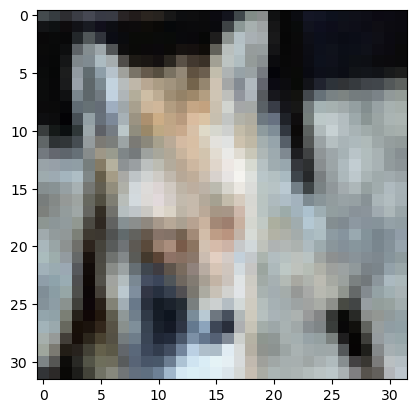

In [52]:
i = np.random.randint(low=0, high=steps_per_epoch_val)

def visualize_result(index):
    image = test_X[i]
    
    y_pred = model(torch.Tensor(image).view(1, 32, 32, 3))
    _, predicted = torch.max(y_pred, 1)
    
    print(y_pred)
    print(label_classes[predicted])
    plt.imshow(Image.fromarray(image))
    

visualize_result(i)

### Визуализация весов

(6, 3, 3, 3)


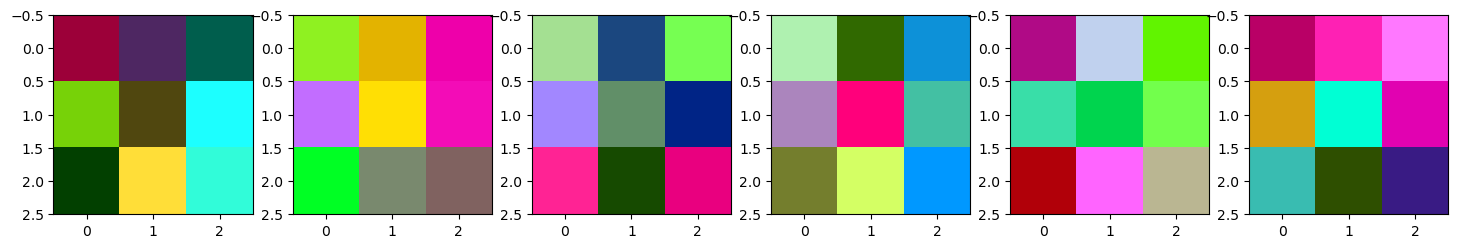

In [53]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
for i, w in enumerate(weights):
    w -= np.percentile(w, 1, axis=[0, 1])
    w /= np.percentile(w, 99, axis=[0, 1])
    w = np.clip(w, 0, 1)
    ax[i].imshow(w)

### Сохранение модели в ONNX

In [54]:
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar_lnn.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = CNN()
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=192, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_f

In [55]:
# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_lnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=192, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_f

In [19]:
#!conda install -c conda-forge onnx --yes

In [56]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to('cpu')
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_LNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})